* ref :https://www.kaggle.com/code/bobby2014king/bike-sharing-demand-byc

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Data Load

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# 전처리 가공

## 날짜 처리

In [3]:
from datetime import datetime
import calendar

def time_process(df):
    df['year'] = pd.DatetimeIndex(df['datetime']).year
    df['month'] = pd.DatetimeIndex(df['datetime']).month
    df['day'] = pd.DatetimeIndex(df['datetime']).day
    df['hour'] = pd.DatetimeIndex(df['datetime']).hour
    df['week'] = pd.DatetimeIndex(df['datetime']).weekofyear
    df['weekday'] = pd.DatetimeIndex(df['datetime']).dayofweek
    return df

train = time_process(train)
test  = time_process(test)

In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,week,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,52,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,52,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,52,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,52,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,52,5


## 풍속 처리

In [5]:
from sklearn.ensemble import RandomForestClassifier
def wind_0_fill(df):
    wind_0 = df[df['windspeed']==0]
    wind_not0 = df[df['windspeed']!=0]
    y_label = wind_not0['windspeed']
    clf = RandomForestClassifier(n_estimators=1000,max_depth=10,random_state=0)
    windcolunms = ['season', 'weather', 'temp', 'atemp', 'humidity', 'hour', 'month']
    clf.fit(wind_not0[windcolunms], y_label.astype('int'))
    pred_y = clf.predict(wind_0[windcolunms])
    wind_0['windspeed'] = pred_y
    df_rfw = wind_not0.append(wind_0)
    df_rfw.reset_index(inplace=True)
    return df_rfw

train = wind_0_fill(train)
test = wind_0_fill(test)

In [6]:
train['datetime']

0        2011-01-01 05:00:00
1        2011-01-01 10:00:00
2        2011-01-01 11:00:00
3        2011-01-01 12:00:00
4        2011-01-01 13:00:00
                ...         
10881    2012-12-17 12:00:00
10882    2012-12-17 15:00:00
10883    2012-12-18 08:00:00
10884    2012-12-18 22:00:00
10885    2012-12-19 00:00:00
Name: datetime, Length: 10886, dtype: object

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       10886 non-null  int64  
 1   datetime    10886 non-null  object 
 2   season      10886 non-null  int64  
 3   holiday     10886 non-null  int64  
 4   workingday  10886 non-null  int64  
 5   weather     10886 non-null  int64  
 6   temp        10886 non-null  float64
 7   atemp       10886 non-null  float64
 8   humidity    10886 non-null  int64  
 9   windspeed   10886 non-null  float64
 10  casual      10886 non-null  int64  
 11  registered  10886 non-null  int64  
 12  count       10886 non-null  int64  
 13  year        10886 non-null  int64  
 14  month       10886 non-null  int64  
 15  day         10886 non-null  int64  
 16  hour        10886 non-null  int64  
 17  week        10886 non-null  int64  
 18  weekday     10886 non-null  int64  
dtypes: float64(3), int64(15),

## 휴무일 처리
* workingday, holiday

In [9]:
dt = pd.DatetimeIndex(train['datetime'])
train.set_index(dt, inplace=True)
dtt = pd.DatetimeIndex(test['datetime'])
test.set_index(dtt, inplace=True)
def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")

#
train.loc[get_day(pd.datetime(2011, 4, 15)), "workingday"] = 1
train.loc[get_day(pd.datetime(2012, 4, 16)), "workingday"] = 1
#
test.loc[get_day(pd.datetime(2011, 11, 25)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 11, 23)), "workingday"] = 0
#
test.loc[get_day(pd.datetime(2011, 12, 24)), "workingday"] = 0
test.loc[get_day(pd.datetime(2011, 12, 31)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 12, 26)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 12, 31)), "workingday"] = 0

#
train.loc[get_day(pd.datetime(2011, 4, 15)), "holiday"] = 0
train.loc[get_day(pd.datetime(2012, 4, 16)), "holiday"] = 0

#
test.loc[get_day(pd.datetime(2011, 11, 25)), "holiday"] = 1
test.loc[get_day(pd.datetime(2012, 11, 23)), "holiday"] = 1
#
test.loc[get_day(pd.datetime(2011, 12, 24)), "holiday"] = 1
test.loc[get_day(pd.datetime(2011, 12, 31)), "holiday"] = 1
test.loc[get_day(pd.datetime(2012, 12, 31)), "holiday"] = 1

#
test.loc[get_day(pd.datetime(2012, 5, 21)), "holiday"] = 1
#
train.loc[get_day(pd.datetime(2012, 6, 1)), "holiday"] = 1

In [10]:
# def name_process(df):
#     df['season2'] = df['season']
#     df['weather2'] = df['weather']
#     df['season2'] = df['season2'].map({1:'Spring',2:'Summer',3:'Fall',4:'Winter'})
#     df['weather2'] = df['weather2'].map({1:'Clear',2:'Mist',3:'Light_Snow',4:'Heavy_Rain'})
#     return df

# train = name_process(train)
# test = name_process(test)

# EDA

<AxesSubplot:xlabel='hour', ylabel='count'>

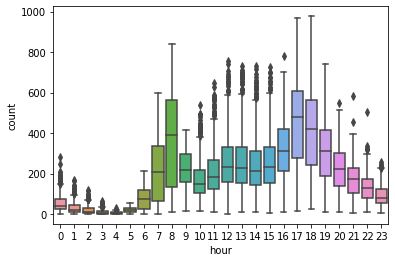

In [11]:
sns.boxplot(x='hour',y='count',data=train)

In [12]:
train['peak'] = train[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)
test['peak'] = test[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)

<AxesSubplot:xlabel='month', ylabel='count'>

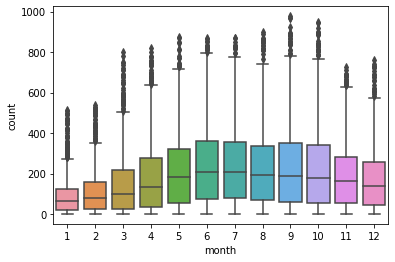

In [13]:
sns.boxplot(x='month',y='count',data=train)

<AxesSubplot:xlabel='hour', ylabel='registered'>

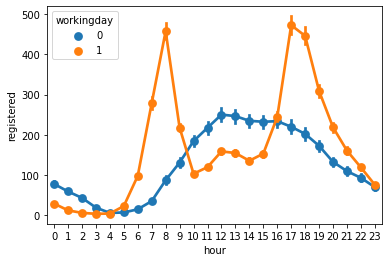

In [14]:
sns.pointplot(x='hour',y='registered',hue='workingday',join=True,data=train)

<AxesSubplot:xlabel='hour', ylabel='casual'>

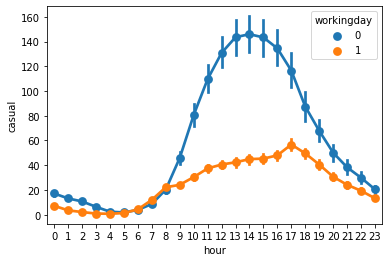

In [15]:
sns.pointplot(x='hour',y='casual',hue='workingday',join=True,data=train)

<AxesSubplot:>

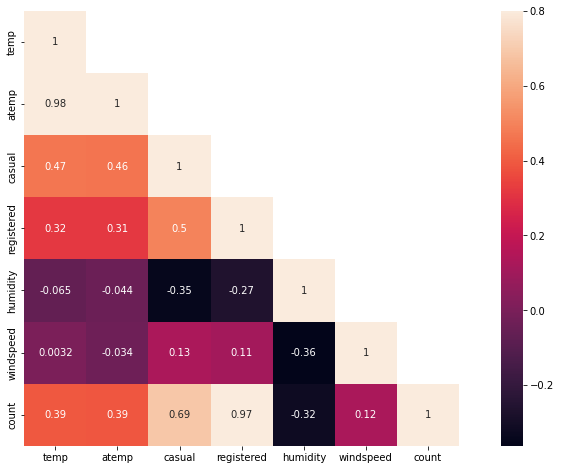

In [16]:
corr = train[['temp','atemp','casual','registered','humidity','windspeed','count']].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches(15,8)
sns.heatmap(corr,mask=mask,vmax=.8,square=True,annot=True)

In [17]:
# train=pd.get_dummies(train,columns=['season2'])
# train=pd.get_dummies(train,columns=['weather2'])

# test=pd.get_dummies(test,columns=['season2'])
# test=pd.get_dummies(test,columns=['weather2'])

# Feature Selection

<font size = 4 color=red><b>Feature Selection의 3가지 방법</b></font>
1. Wrapper method : 모델링 돌리면서 변수 채택
2. Filter Method : 전처리단에서 통계기법 사용하여 변수 채택
3. Embedded method : 라쏘, 릿지, 엘라스틱넷 등 내장함수 사용하여 변수 채택  

ref : https://dyddl1993.tistory.com/18
ref : https://subinium.github.io/feature-selection/

In [18]:
# All_feature_columns = ['season' ,'weather','temp','atemp','humidity' 
#                        ,'windspeed', 'year','holiday','workingday','month','day','hour','week','weekday','peak',
#                        'season2_Fall','season2_Spring','season2_Summer','season2_Winter',
#                        'weather2_Clear','weather2_Heavy_Rain','weather2_Light_Snow','weather2_Mist']

# RFR_feature_columns = ['season' ,'weather','temp','atemp' #,'humidity'
#                        ,'windspeed'                       #,'year'
#                        ,'holiday','workingday'            #,'month','day'
#                        ,'hour' ,'week','weekday','peak'
#                        , 'season2_Fall','season2_Spring','season2_Summer','season2_Winter'
#                        , 'weather2_Clear','weather2_Heavy_Rain','weather2_Light_Snow','weather2_Mist']

# GBR_feature_columns = ['season','weather','temp','atemp','humidity'
#                        ,'windspeed','year'                        #,'month','day'
#                        ,'holiday','workingday','hour','weekday'    #'week','peak'
#                        , 'season2_Fall','season2_Spring','season2_Summer','season2_Winter'
#                        , 'weather2_Clear','weather2_Heavy_Rain','weather2_Light_Snow','weather2_Mist']

In [19]:
RFR_feature_columns = ['weather', 'temp'            , 'windspeed'          ,'workingday', 'season', 'holiday','hour', 'weekday', 'week', 'peak']
GBR_feature_columns = ['weather', 'temp', 'humidity', 'windspeed','holiday','workingday', 'season'           ,'hour', 'weekday'                ,'year']

In [22]:
RFR_X_train=train[RFR_feature_columns].values
RFR_X_test=test[RFR_feature_columns].values

GBR_X_train=train[GBR_feature_columns].values
GBR_X_test=test[GBR_feature_columns].values

y_casual     = train['casual'].apply(lambda x: np.log1p(x)).values
y_registered = train['registered'].apply(lambda x: np.log1p(x)).values
y_count      = train['count'].apply(lambda x: np.log1p(x)).values

X_date = test['datetime'].values

# RMSLE

$ \sqrt{ \frac{1}{n} \sum_{i=1}^{n}{ (\log( y_i + 1) - \log( \hat{y_i} + 1))^2} } $
$ = \sqrt{ \frac{1}{n} \sum_{i=1}^{n}{ (\log \frac {y_i + 1} {\hat{y_i} + 1} )^2} } $
<pre>
<B>1) 상대적 Error 측정</B>
  예측값 = 100,    실제값 = 90일 때,    RMSE = 10,    RMSLE = 0.1053
  예측값 = 10,000, 실제값 = 9,000일 때, RMSE = 1,000, RMSLE = 0.1053
<B>2) Outlier에 강건</B>
  예측값 = 67, 78, 91,      실제값 = 60, 80, 90일 때,     RMSE = 4.242,   RMSLE = 0.6466
  예측값 = 67, 78, 91, 102, 실제값 = 60, 80, 90, 750일 때 RMSE = 374.724, RMSLE = 1.160
<B>3) Under Estimation에 큰 패널티 부여</B>
   Over Estimation(예측값>실제값) , Under Estimation(예측값＜실제값)
   예측값 = 600,   실제값 = 1,000일 때 RMSE = 400, RMSLE = 0.510
   예측값 = 1,400, 실제값 = 1,000일 때 RMSE = 400, RMSLE = 0.33
   

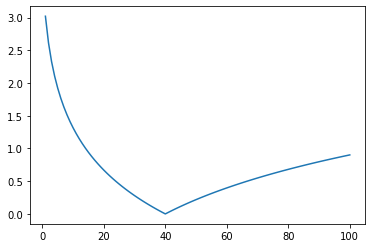

In [23]:
 # RMSLE
p = np.arange(1,101)
a = np.array([40]*100)
rmsle = np.sqrt(  (np.log(p+1) - np.log(a+1) )**2  ) 
plt.plot(p,rmsle)


In [24]:
def rmsle(y_real, y_pre):    
    calc = ( np.log(y_pre+1) - np.log(y_real+1)) ** 2
    return np.sqrt(np.mean(calc))

# train test 분리

In [25]:
train.drop(['index','datetime', 'casual','registered','count'], axis=1, inplace=True)
test.drop(['index','datetime'], axis=1, inplace=True)

In [26]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,week,weekday,peak
datetime,,,,,,,,,,,,,,,
2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,2011,1,1,5,52,5,0
2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,2011,1,1,10,52,5,1
2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,2011,1,1,11,52,5,1
2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,2011,1,1,12,52,5,1
2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,2011,1,1,13,52,5,1


In [27]:
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,week,weekday,peak
datetime,,,,,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3,3,0
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3,3,0
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,3,3,0
2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013,2011,1,20,5,3,3,0
2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013,2011,1,20,6,3,3,0


# Model Selection

## 모델 성능 비교

In [38]:
from sklearn.model_selection import train_test_split
# X_train = train[All_feature_columns].values
X_train = train.values
xd_train,xd_test,yd_train,yd_test = train_test_split(X_train,y_count,random_state=0)

# ------------------------------------------------------------------------------------------------------------------
##LGBM 
from lightgbm import LGBMRegressor
def LGBM_model():
    LGBM = LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=1200,
                                learning_rate=0.17, n_estimators=1000, max_depth=10,
                                metric='rmse', bagging_fraction=0.8, feature_fraction=0.8, reg_lambda=0.9)
    LGBM.fit(xd_train, yd_train)
    pre_test = LGBM.predict(xd_test)
    score = rmsle(yd_test,pre_test)
    s = pd.Series(data=LGBM.feature_importances_, index=train.columns)
    print(s.sort_values(ascending=False))
    return score

# ------------------------------------------------------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
def RandomForest_model():
    RFR = RandomForestRegressor(n_estimators = 1000, max_depth=15, random_state=0,n_jobs = -1)
    RFR.fit(xd_train,yd_train)
    pre_test = RFR.predict(xd_test)
    score = rmsle(yd_test,pre_test)
    s = pd.Series(data=RFR.feature_importances_, index=train.columns)
    print(s.sort_values(ascending=False))
    s.sort_values(ascending=False).plot.bar()
    plt.show()
    plt.close()
    return score

# ------------------------------------------------------------------------------------------------------------------
from sklearn.ensemble import GradientBoostingRegressor
def GradientBoosting_model():
    GBR = GradientBoostingRegressor(n_estimators = 1000, max_depth = 5, random_state = 0)
    GBR.fit(xd_train,yd_train)
    pre_test = GBR.predict(xd_test)
    score = rmsle(yd_test,pre_test)
    s = pd.Series(data=GBR.feature_importances_, index=train.columns)
    print(s.sort_values(ascending=False))
    s.sort_values(ascending=False).plot.bar()
    plt.show()
    plt.close()
    return score


# ------------------------------------------------------------------------------------------------------------------
from sklearn.tree import DecisionTreeRegressor
def DecisionTree_model():
    DTR = DecisionTreeRegressor(max_features='sqrt', splitter='random', min_samples_split=4, max_depth=10)
    DTR.fit(xd_train,yd_train)
    pre_test = DTR.predict(xd_test)
    score = rmsle(yd_test,pre_test)
    s = pd.Series(data=DTR.feature_importances_, index=train.columns)
    print(s.sort_values(ascending=False))
    return score


# ------------------------------------------------------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
def Logisic_model():
    LG = LogisticRegression(penalty="l2",tol=0.0001, C=1.0, solver= "lbfgs", max_iter=3000,multi_class='ovr', verbose=O)
    LG.fit(xd_train,yd_train)
    pre_test = LG.predict(xd_test)
    score = rmsle(yd_test,pre_test)
    s = pd.Series(data=LG.feature_importances_, index=train.columns)
    print(s.sort_values(ascending=False))
    return score

# ------------------------------------------------------------------------------------------------------------------
##AdaBoost
from sklearn.ensemble import AdaBoostRegressor
def AdaBoost_model():
    ABR = AdaBoostRegressor(learning_rate=0.1, loss='square', n_estimators=1000)
    ABR.fit(xd_train,yd_train)
    pre_test = ABR.predict(xd_test)
    score = rmsle(yd_test,pre_test)
    s = pd.Series(data=ABR.feature_importances_, index=train.columns)
    print(s.sort_values(ascending=False))
    return score

hour          0.717391
peak          0.045172
workingday    0.041456
temp          0.037987
year          0.032547
week          0.027615
weekday       0.021329
month         0.017644
humidity      0.016422
atemp         0.011833
weather       0.009829
windspeed     0.007217
season        0.006427
day           0.006221
holiday       0.000912
dtype: float64


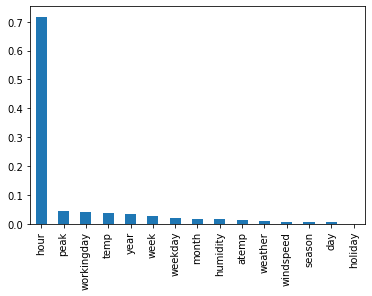

RandomForest_model:      0.08396553802057821
hour          0.723553
workingday    0.046454
peak          0.040801
temp          0.038444
year          0.032732
weekday       0.027890
month         0.020968
week          0.019932
humidity      0.014456
weather       0.011474
atemp         0.009244
season        0.005333
windspeed     0.004390
day           0.003671
holiday       0.000657
dtype: float64


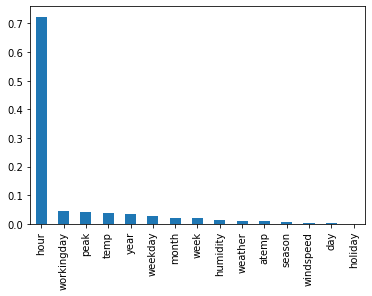

GradientBoosting_model:  0.08338951555062715


In [39]:
# print("LGBM_model:             ",LGBM_model())
print("RandomForest_model:     ",RandomForest_model())
# print("DecisionTree_model:     ",DecisionTree_model())
print("GradientBoosting_model: ",GradientBoosting_model())
# print("AdaBoost_model:         ",AdaBoost_model())

In [20]:
GBR_feature_columns = ['hour','month', 'year','atemp' ,'humidity' , 'peak' , 'workingday' , 'weekday','windspeed' ,'week']
GBR_feature_columns = ['weather', 'temp', 'windspeed','holiday','workingday', 'season','hour', 'weekday'          ,'humidity', 'year']
    
# hour          0.467933
# month         0.091895  ----
# year          0.072871
# atemp         0.052749  ----
# humidity      0.049934
# peak          0.049397  ----
# workingday    0.046351
# weekday       0.045405
# windspeed     0.033989
# week          0.028676  -------------------
# temp          0.022474
# weather       0.016588
# day           0.015911  ----
# season        0.005827
# holiday       0.000000

In [21]:
RFR_feature_columns = ['hour', 'peak','workingday', 'temp', 'year','week','weekday', 'month','humidity'] #,  'weather' , 'windspeed'  , 'season', 'holiday']
RFR_feature_columns = ['weather', 'temp', 'windspeed' , 'holiday' ,'workingday', 'season','hour', 'weekday'      , 'week', 'peak']

# hour          0.717391
# peak          0.045172
# workingday    0.041456
# temp          0.037987
# year          0.032547  ----
# week          0.027615
# weekday       0.021329
# month         0.017644  ----
# humidity      0.016422  ------------------------
# atemp         0.011833  
# weather       0.009829
# windspeed     0.007217
# season        0.006427
# day           0.006221  ----
# holiday       0.000912

## 파라미터 튜닝

In [30]:
# ------------------------------------------------------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
params = {'n_estimators': 1000, 
          'max_depth': 15, 
          'random_state': 0, 
          'min_samples_split' : 5, 
          'n_jobs': -1}

RFR1 = RandomForestRegressor(**params)
RFR1.fit(RFR_X_train,y_casual)
print("model:",RFR1.score(RFR_X_train,y_casual))

RFR2 = RandomForestRegressor(**params)
RFR2.fit(RFR_X_train,y_registered)
print("model:",RFR2.score(RFR_X_train,y_registered))

RFR3 = RandomForestRegressor(**params)
RFR3.fit(RFR_X_train,y_count)
print("model:",RFR3.score(RFR_X_train,y_count))

model: 0.9668050121659433
model: 0.985992884723989
model: 0.9859414825931789


In [31]:
RandomForestRegressor

sklearn.ensemble._forest.RandomForestRegressor

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

params2 = {'n_estimators': 150, 
           'max_depth': 5, 
           'random_state': 0, 
           'min_samples_leaf' : 10, 
           'learning_rate': 0.1, 
           'subsample': 0.7, 
           'loss': 'ls'}

GBR1 = GradientBoostingRegressor(**params2)
GBR1.fit(GBR_X_train,y_casual)
print("model:",GBR1.score(GBR_X_train,y_casual))

GBR2 = GradientBoostingRegressor(**params2)
GBR2.fit(GBR_X_train,y_registered)
print("model:",GBR2.score(GBR_X_train,y_registered))

GBR3 = GradientBoostingRegressor(**params2)
GBR3.fit(GBR_X_train,y_count)
print("model:",GBR3.score(GBR_X_train,y_count))

model: 0.9226361640002755
model: 0.9679279836575722
model: 0.9679086498860243


## 앙상블

In [33]:
# -------------------------------------------------------------
RFR_pre_casual = RFR1.predict(RFR_X_test)
RFR_pre_casual=np.exp(RFR_pre_casual)-1

RFR_pre_registered = RFR2.predict(RFR_X_test)
RFR_pre_registered=np.exp(RFR_pre_registered)-1

RFR_pre = RFR_pre_casual+RFR_pre_registered
# -------------------------------------------------------------

GBR_pre_casual = GBR1.predict(GBR_X_test)
GBR_pre_casual=np.exp(GBR_pre_casual)-1

GBR_pre_registered = GBR2.predict(GBR_X_test)
GBR_pre_registered=np.exp(GBR_pre_registered)-1

GBR_pre = GBR_pre_casual+GBR_pre_registered
# -------------------------------------------------------------Score: 0.35587



# make submission

In [ ]:
submit1 = pd.DataFrame({'datetime':X_date,'count':0.2*RFR_pre+0.8*GBR_pre})
submit1.to_csv('lkh02.csv',index=False)

In [34]:
# submit1.to_csv('0.35587.csv',index=False)

In [35]:
# # -------------------------------------------------------------
# RFR_pre_count = RFR3.predict(RFR_X_test)
# RFR_pre_count = np.exp(RFR_pre_count)-1

# GBR_pre_count = GBR3.predict(GBR_X_test)
# GBR_pre_count = np.exp(GBR_pre_count)-1

# pre_count=0.2*RFR_pre_count+0.8*GBR_pre_count
# # -------------------------------------------------------------  Score: 0.35957

# submit2 = pd.DataFrame({'datetime':X_date,'count':pre_count})
# submit2.to_csv('lkh03.csv',index=False)

<img src="./board2.png">  